# Removing duplicates

In [8]:
import os
import hashlib

# Function to calculate hash of a file
def calculate_file_hash(file_path):
    with open(file_path, "rb") as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
    return file_hash

# Directory path
dataset_directory = "C:/Users/HP/Downloads/tea leaf/categories"

# Dictionary to store file hashes
file_hashes = {}

# List to store duplicate files
duplicate_files = []

# Iterate over files in the directory
for filename in os.listdir(dataset_directory):
    file_path = os.path.join(dataset_directory, filename)
    # Check if the path is a file
    if os.path.isfile(file_path):
        file_hash = calculate_file_hash(file_path)
        # Check if the file hash already exists
        if file_hash in file_hashes:
            duplicate_files.append(filename)
        else:
            file_hashes[file_hash] = file_path

# Remove duplicate files
for duplicate_file in duplicate_files:
    os.remove(os.path.join(dataset_directory, duplicate_file))

print("Duplicates removed successfully!")


Duplicates removed successfully!


# Displaying number of images in each categories

In [9]:
import os

# Define the path to the main categories folder
main_categories_path = "C:/Users/HP/Downloads/tea leaf/categories"

# Initialize dictionaries to store the count of images
image_count = {}
infected_image_count = {}

# Traverse through the main categories folder
for category in os.listdir(main_categories_path):
    category_path = os.path.join(main_categories_path, category)
    
    # Check if it's a directory
    if os.path.isdir(category_path):
        # Initialize count for the category
        count = 0
        
        # Traverse through subfolders if category is "infected"
        if category == "infected":
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                
                # Check if it's a directory
                if os.path.isdir(subfolder_path):
                    # Count the number of image files
                    subfolder_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.jpg')])
                    infected_image_count[subfolder] = subfolder_count
                    count += subfolder_count
        else:  # For other categories directly count the images
            count = len([f for f in os.listdir(category_path) if f.endswith('.jpg')])
        
        # Store the count in the dictionary
        image_count[category] = count

# Print the count of images in each category
print("Number of images in each category:")
for category, count in image_count.items():
    print(f"{category}: {count}")

# Print the count of images in each subfolder of "infected" category
print("\nNumber of images in each subfolder of 'infected' category:")
for subfolder, count in infected_image_count.items():
    print(f"{subfolder}: {count}")


Number of images in each category:
healthy: 197
infected: 1292

Number of images in each subfolder of 'infected' category:
algal leaf: 195
Anthracnose: 100
bird eye spot: 100
brown blight: 183
gray blight: 170
helopeltis: 200
red leaf spot: 207
white spot: 137


# Level 1 Classification

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [13]:

# Path to the dataset
dataset_directory = "C:/Users/HP/Downloads/tea leaf/categories"

# Specify image preprocessing parameters
target_width = 128
target_height = 128
batch_size = 32
epochs = 20

# Image data generator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the entire dataset using flow_from_directory
data_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=(target_width, target_height),
    batch_size=batch_size,
    class_mode='binary',  # Since it's a binary classification problem
    shuffle=True,
    seed=42
)

# Extract features and labels from the generator
X, y = [], []
for _ in range(len(data_generator)):
    batch_X, batch_y = data_generator.next()
    X.append(batch_X)
    y.append(batch_y)
X = np.concatenate(X)
y = np.concatenate(y)




Found 1489 images belonging to 2 classes.


10/10 [==============================] - 1s 42ms/step
Overall Accuracy: 90.73%
Overall Precision: 0.95
Overall Recall: 0.94
Overall F1-Score: 0.95


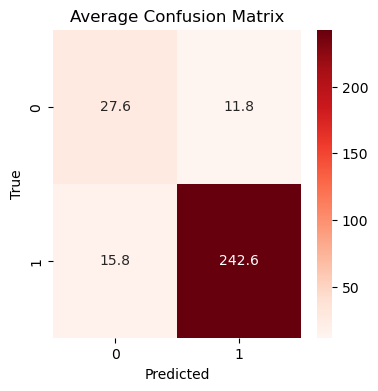

In [14]:
# Define CNN architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_model()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

# Print evaluation metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"Overall Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Overall Precision: {avg_precision:.2f}")
print(f"Overall Recall: {avg_recall:.2f}")
print(f"Overall F1-Score: {avg_f1:.2f}")

# Average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(4, 4))
sns.heatmap(avg_conf_matrix, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

In [18]:
 # Print confusion matrix for this fold
print(f"Confusion Matrix for fold {skf}:")
print(conf_matrices[-1])
print()  # Add a blank line for better readability

Confusion Matrix for fold StratifiedKFold(n_splits=5, random_state=42, shuffle=True):
[[ 29  10]
 [ 12 246]]



# Level 2 Classification

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:


import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define paths for each disease category
disease_paths = {
    "red leaf spot": "C:/Users/HP/Downloads/tea leaf/categories/infected/red leaf spot",
    "white spot": "C:/Users/HP/Downloads/tea leaf/categories/infected/white spot",
    "algal leaf": "C:/Users/HP/Downloads/tea leaf/categories/infected/algal leaf",
    "gray blight": "C:/Users/HP/Downloads/tea leaf/categories/infected/gray blight",
    "anthracnose": "C:/Users/HP/Downloads/tea leaf/categories/infected/anthracnose",
    "bird eye spot": "C:/Users/HP/Downloads/tea leaf/categories/infected/bird eye spot",
    "brown blight": "C:/Users/HP/Downloads/tea leaf/categories/infected/brown blight",
     "helopeltis": "C:/Users/HP/Downloads/tea leaf/categories/infected/helopeltis",
    "healthy":"C:/Users/HP/Downloads/tea leaf/categories/healthy"
}

# Initialize lists to store features and labels
X = []
y = []

# Load and preprocess images
for disease, path in disease_paths.items():
    for filename in os.listdir(path):
        if not filename.endswith('.DS_Store'):
            image_path = os.path.join(path, filename)
            img = load_img(image_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            X.append(img_array)
            y.append(disease)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Use LabelEncoder to encode categorical labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Shuffle the data
X, y_encoded = shuffle(X, y_encoded, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50
                    , validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)



Epoch 1/50
38/38 [==============================] - 68s 2s/step - loss: 2.0398 - accuracy: 0.4114 - val_loss: 1.9359 - val_accuracy: 0.4060
Epoch 2/50
38/38 [==============================] - 55s 1s/step - loss: 1.3197 - accuracy: 0.5550 - val_loss: 1.0468 - val_accuracy: 0.6174
Epoch 3/50
38/38 [==============================] - 50s 1s/step - loss: 1.2224 - accuracy: 0.5760 - val_loss: 1.3854 - val_accuracy: 0.5470
Epoch 4/50
38/38 [==============================] - 58s 2s/step - loss: 1.0472 - accuracy: 0.6516 - val_loss: 0.9170 - val_accuracy: 0.6980
Epoch 5/50
38/38 [==============================] - 71s 2s/step - loss: 1.0191 - accuracy: 0.6289 - val_loss: 0.9503 - val_accuracy: 0.6745
Epoch 6/50
38/38 [==============================] - 54s 1s/step - loss: 0.9311 - accuracy: 0.6751 - val_loss: 0.9099 - val_accuracy: 0.6913
Epoch 7/50
38/38 [==============================] - 72s 2s/step - loss: 0.8616 - accuracy: 0.6860 - val_loss: 0.9539 - val_accuracy: 0.6779
Epoch 8/50
38/38 [==

               precision    recall  f1-score   support

   algal leaf       0.64      0.92      0.75        38
  anthracnose       0.90      0.82      0.86        22
bird eye spot       0.91      0.71      0.80        14
 brown blight       0.81      0.49      0.61        35
  gray blight       0.73      0.84      0.78        38
      healthy       0.91      0.73      0.81        41
   helopeltis       0.71      0.92      0.80        37
red leaf spot       0.79      0.80      0.80        46
   white spot       0.84      0.59      0.70        27

     accuracy                           0.77       298
    macro avg       0.80      0.76      0.77       298
 weighted avg       0.79      0.77      0.76       298



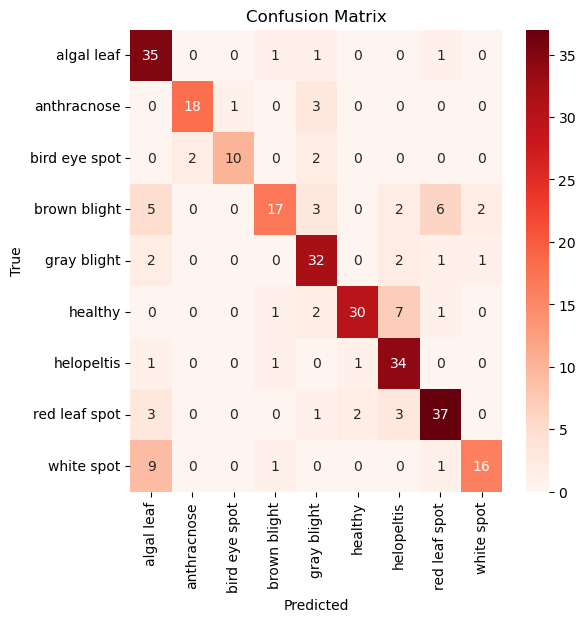

F1 Score: 0.7644155451566206
Precision: 0.7889579078777129
Recall: 0.7684563758389261


In [4]:
# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print F1 score, precision, recall
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


In [5]:
# Save the trained model in the recommended format
model.save("cnnlevel3.keras")

# GUI

In [6]:
import tkinter as tk
from tkinter import filedialog, Label, Button, Frame, Canvas
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf



In [ ]:
# Load the saved CNN model
model = tf.keras.models.load_model("cnnlevel3.keras")

# Define the class labels used during training
class_labels = ['Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight', 'Gray Blight', 'Healthy','Helopeltis','Red leaf spot','White Spot',]

# Define function to preprocess the uploaded image
def preprocess_image(file_path):
    img = Image.open(file_path)
    img = img.resize((128, 128))  # Resize image to match model input shape
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Define function to classify uploaded image
def classify_image():
    file_path = filedialog.askopenfilename()  # Open file dialog to select image
    if file_path:
        try:
            # Preprocess the image
            img_array = preprocess_image(file_path)

            # Make prediction using the model
            prediction = model.predict(img_array)
            predicted_class_index = np.argmax(prediction)

            # Get the disease name corresponding to the predicted class index
            predicted_disease = class_labels[predicted_class_index]

            # If the predicted label is "Healthy" and its probability is below the threshold, select the label with the highest probability among diseases
            if predicted_disease == 'Healthy' and prediction[0, predicted_class_index] < 0.5:
                max_index = np.argsort(prediction[0, :-1])[-1]
                predicted_disease = class_labels[max_index]

            # Display the uploaded image
            img = Image.open(file_path)
            img = img.resize((300, 300))  # Resize image for display
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img

            # Update result label text with the predicted disease name
            result_label.config(text=f"Predicted Disease: {predicted_disease}", fg="black")  # Set text color to black

        except Exception as e:
            # Load and display the invalid image
            invalid_img = Image.open("invalid_image.jpg")
            invalid_img = invalid_img.resize((300, 300))  # Resize image for display
            invalid_img = ImageTk.PhotoImage(invalid_img)
            panel.configure(image=invalid_img)
            panel.image = invalid_img

            # Update result label text to indicate invalid image
            result_label.config(text="INVALID IMAGE !", fg="red")  # Set text color to red

# Create Tkinter GUI
root = tk.Tk()
root.title("Tea Leaf Disease Detector")
root.geometry("700x500")

# Load and display farm image
farm_img = Image.open("farm.jpg")
farm_img = farm_img.resize((700, 500))  # Resize image to match window size
farm_img = ImageTk.PhotoImage(farm_img)
canvas = Canvas(root, width=700, height=500)
canvas.pack()
canvas.create_image(350, 250, anchor="center", image=farm_img)  # Adjust anchor to center

# Frame to hold the image panel and result label
image_frame = Frame(root, bg="white")
image_frame.place(relx=0.5, rely=0.5, anchor="center")

# Add panel to display uploaded image
panel = Label(image_frame)
panel.pack()

# Add result label to display the predicted disease
result_label = Label(root, text="", font=('times new roman', 16,'bold'), bg="white")
result_label.place(relx=0.5, rely=0.85, anchor="center")

# Frame to hold the upload button
button_frame = Frame(root, bg="white")
button_frame.place(relx=0.5, rely=0.95, anchor="center")  # Adjust rely to position the frame higher

# Add button to upload image with light blue background color and white text
upload_button = Button(button_frame, text="Upload Image", command=classify_image, bg='#4682B4', fg='white', font=('times new roman', 14))
upload_button.pack()

# Add title label
title_label = Label(root, text="Tea Leaf Disease Detector ", font=('times new roman', 24, 'bold'), bg="white")
title_label.place(relx=0.5, rely=0.1, anchor="center")

# Run Tkinter event loop
root.mainloop()


1/1 [==============================] - 0s 78ms/step
